### Box 5, Step 1	
First, create a folder called ‘fitted’ in your working data directory, where all results of the fitting steps will be stored.
### Step 2
Batch-process the images in the data set to detect lasing peaks and store their spatial, spectral, and temporal position in pre-processed text files.
#### i.
For regular hyperspectral confocal data sets, call the fitSpectraToFiles method (Supplementary Code 2, Box 1). The processed text files are organized into separate columns for each spectrum, where each columns holds information on the position and intensity of the lasing spectrum, followed by a list of the detected peaks, whose precise peak position is determined by fitting a gaussian to the experimental data.
#### ii.
Specify additional settings for the peak detection, which are explained in Supplementary Note 3. 

In [1]:
from acquisitionExtended import * #processing data class and dependencies
#for style
display(HTML("<style>.container { width:80% !important; }</style>"))
plt.style.use('dark_background')
#warnings are disabled in thoroughly tested code to improve legibility
import warnings
warnings.filterwarnings("ignore")

#define location and name of dataset
directoryName='Z:\\Data for Setup Paper\\20220413\\'
logName='Log_2022-04-13_07-01PM.txt'
dataName='DIW_10x_FluoRed_AgaroseSensing_FOV2'

#create an instance of the acquisition class to run the auto-calibration routine
Scan0=acquisition(directoryName, dataName)
Scan0.autoCalibrate(logName, FOV50=1733.85)

#fit all peaks - calibration data set
#Scan0.fitSpectraToFiles( tol=50, tol2=50, height=10, thresh=60, noPeaks=4) #uncomment this to run the fitting

#### iii.
Alternatively, one can batch-process ascii files containing a sequence of spectra, which would be beneficial to apply our multimode spectra routine to a data set acquired on a different camera (e.g., Andor Newton camera). To use the ascii function, ensure the ascii file contains the wavelength axis information in its first column, and the spectra in all following columns, which will be interpreted as spectra from a single position at consecutive time-step (Supplementary Code 2, Box 2).

In [2]:
#ascii importer
importer='not implemented'

### Step 6	
Generate result traces from fixed positions (RIU vs time) (Supplementary Code 2, Box 3-4).

In [3]:
#retrieve the results of the fit 
nMap, iMap = Scan0.ResultsFromFiles( param='n', maxRes=4*10**(-11)) #n for refractive index
dMap, iMap = Scan0.ResultsFromFiles( param='d', maxRes=4*10**(-11)) #d for diameter of the bead
pMap, pMap2 = Scan0.ResultsFromFiles( param='peak', maxRes=4*10**(-11)) #peak for two lasing peaks (typically, TE/TM but the ordering is random)

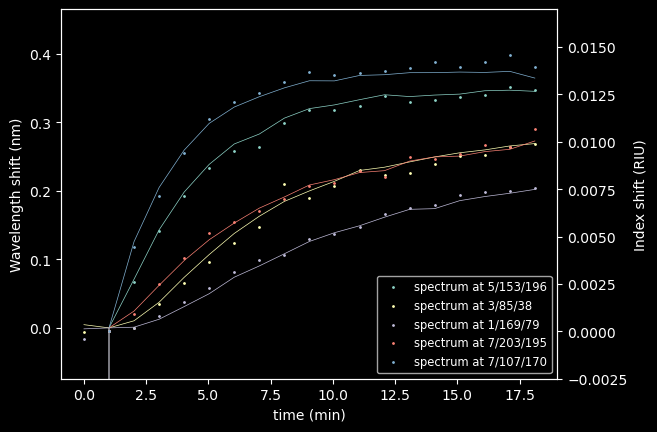

In [4]:
#create time axis for plotting
time=np.array(range(19))*Scan0.tStep

#define x/y/z positions at which spectra should be extracted
z=[5, 3, 1, 7, 7]
x=[153, 85, 169, 203, 107]
y=[196, 38, 79, 195, 170]

#plot traces
plt.figure()
for i in range(len(z)):
    #define a position
    z0=z[i]
    x0=x[i]
    y0=y[i]
    #extract wavelength trace
    peak0=pMap[:,z0, x0, y0]
    plt.plot(time, peak0-peak0[1], lw=0.5)
    plt.ylim(-0.07416, 0.46504)
    plt.ylabel('Wavelength shift (nm)')
    plt.xlabel('time (min)')
ax2=plt.twinx()
for i in range(len(z)):
    #define a position
    z0=z[i]
    x0=x[i]
    y0=y[i]
    #extract refractive index 
    n0=nMap[:,z0, x0, y0]
    ax2.scatter(time, n0-n0[1], label='spectrum at {}/{}/{}'.format(z0, x0, y0), s=1)
    ax2.set_ylim(-0.0025, 0.017)
plt.legend(fontsize='small')
ax2.set_ylabel('Index shift (RIU)')
plt.savefig(Scan0.directory+'SensingTraces.svg')
plt.show()

### Step 7
Fitted results from hyperspectral confocal scans can be displayed as images with custom color-coding representing various physical quantities. Call the cmapResultsFromFiles and specify which parameter is imported in the returned RGBA maps (fitted refractive index, fitted bead diameter, or the lasing peak position; Supplementary Figure 11 and Supplementary Code 2, Box 5).

In [5]:
R, G, B = Scan0.cmapResultsFromFiles(15.5, 17, param='d', maxRes=4*10**(-11)) #size map
R2, G2, B2 = Scan0.cmapResultsFromFiles(1.330, 1.350, param='n', maxRes=4*10**(-11)) #refractive index map

### Step 8	
Display the ND-RGBA results in napari and export screenshots as described in Step 8 (Supplementary Code 2, Box 6-7).

In [6]:
rot=[0,0,0]
scale0=[Scan0.zStep, Scan0.yStep, Scan0.xStep]
Lim=[10,1300]

#export refractive index color coded map at the 8th timestep
t=8
viewer=napari.view_image(R[t, :, 47:297, 0:260], colormap='red', interpolation='nearest', blending='additive', contrast_limits=Lim, scale=scale0, rotate=rot, ndisplay=3 )
viewer.add_image(G[t, :, 47:297, 0:260], colormap='green', interpolation='nearest', blending='additive', contrast_limits=Lim, scale=scale0, rotate=rot)
viewer.add_image(B[t, :, 47:297, 0:260], colormap='blue', interpolation='nearest', blending='additive', contrast_limits=Lim, scale=scale0, rotate=rot ) 
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"
viewer.camera.zoom=0.5
viewer.window.screenshot(directoryName+'indexMap_1.33-1.35_frame{}.tif'.format(t))
viewer.close()

### Step 9
More accurate results for the absolute refractive index can be achieved with the following calibration step, using data measured at Steps 83-85. 
#### i.
Detect the lasing peaks following the same instructions as Step 2. 

In [7]:
#define location and name of calibration dataset
directoryName='Z:\\Data for Setup Paper\\20220413\\'
logName='Log_2022-04-13_06-01PM.txt'
dataName='DIW_10x_FluoRed_Calibration_OD60'

#create an instance of the acquisition class to run the auto-calibration routine
ScanC=acquisition(directoryName, dataName)
ScanC.autoCalibrate(logName, FOV50=1733.85)

#fit all peaks - calibration data set
ScanC.fitSpectraToFiles(tol=50, tol2=50, height=10, thresh=60, noPeaks=6)

Open the asymptoticExpansionCalibration script in MATLAB and change the name of the data set and directory.
#### ii.
Specify the known refractive index of your calibration data set, e.g., 1.33 for DIW. 
#### iii.
Leave the bounds of the diameter relatively open to account for divergence from the nominal size of the microbead lasers. 
#### iv.
The script will return an internal refractive index and the spread of bead diameters. Update the internal refractive in the fitting script (Step 4-5) and the bounds of the diameter to reflect the size spread measured during the calibration. 

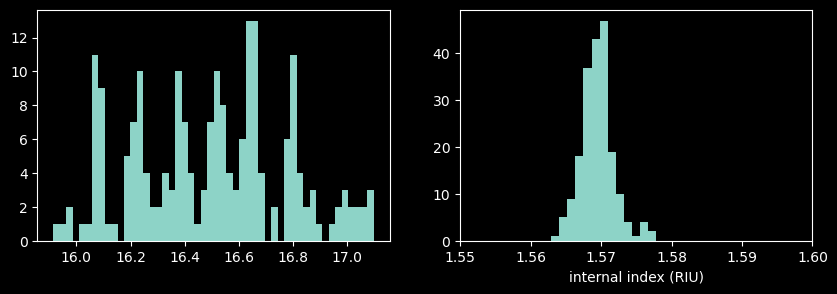

In [8]:
calibrationResults=np.loadtxt(Scan0.directory+'fitted\\calibration_result.txt')

allIntIndeces=calibrationResults[0]
allSizes=calibrationResults[1]
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax0, ax1 = ax
ax1.hist(allIntIndeces, bins=50)
ax0.hist(allSizes, bins=50)
ax1.set_xlabel('internal index (RIU)')
ax1.set_xlim(1.55, 1.6)
ax2.set_xlabel('internal index (um)')
plt.show()